In [1]:
import numpy as np
from tsai.all import *
import sklearn.metrics as skm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
    torch.use_deterministic_algorithms(True, warn_only=True)

In [3]:
set_seed(1337)

In [4]:
num_epochs = 100
few_shot_patience = 5

In [5]:
df = pd.read_pickle('togzhan_data_labeled.pkl').reset_index(drop=True)
df['Trial ID'] = df['Person No'].astype(str) + '_' + df['Trial No'].astype(str)

# Load the new doctors data
doctors_df = pd.read_pickle('doctors_data_labeled.pkl').reset_index(drop=True)
doctors_df['Trial ID'] = doctors_df['Person No'].astype(str) + '_' + df['Trial No'].astype(str)

# Create new columns for labels in both datasets
for data in [df, doctors_df]:
    data['Lump'] = data['Type'].apply(lambda x: 1 if x < 9 else 0)

def split_trials(data, train_lump_count, val_lump_count, test_lump_count, train_no_lump_count, val_no_lump_count, test_no_lump_count):
    train_trials = []
    val_trials = []
    test_trials = []

    for person_no in data['Person No'].unique():
        person_df = data[data['Person No'] == person_no]

        for lump_type in range(9):  # 9 types with lump
            lump_df = person_df[person_df['Type'] == lump_type]
            lump_train, lump_temp = train_test_split(lump_df, test_size=(val_lump_count + test_lump_count), random_state=1337)
            lump_val, lump_test = train_test_split(lump_temp, test_size=test_lump_count, random_state=1337)
            
            train_trials.extend(lump_train.index.tolist())
            val_trials.extend(lump_val.index.tolist())
            test_trials.extend(lump_test.index.tolist())

        for no_lump_type in range(9, 13):  # 4 types without lump
            no_lump_df = person_df[person_df['Type'] == no_lump_type]
            no_lump_train, no_lump_temp = train_test_split(no_lump_df, test_size=(val_no_lump_count + test_no_lump_count), random_state=1337)
            no_lump_val, no_lump_test = train_test_split(no_lump_temp, test_size=test_no_lump_count, random_state=1337)
            
            train_trials.extend(no_lump_train.index.tolist())
            val_trials.extend(no_lump_val.index.tolist())
            test_trials.extend(no_lump_test.index.tolist())

    # Ensure there is no overlap between train, validation, and test sets
    train_trials = set(train_trials)
    val_trials = set(val_trials)
    test_trials = set(test_trials)

    assert len(train_trials & val_trials) == 0, "Train and Validation sets overlap!"
    assert len(train_trials & test_trials) == 0, "Train and Test sets overlap!"
    assert len(val_trials & test_trials) == 0, "Validation and Test sets overlap!"

    return train_trials, val_trials, test_trials

# Define counts for train, validation, and test trials per person
train_lump_count = 20
val_lump_count = 8
test_lump_count = 4

train_no_lump_count = 48
val_no_lump_count = 18
test_no_lump_count = 9

# Split trials for each person
train_trials, val_trials, test_trials = split_trials(
    df,
    train_lump_count=train_lump_count,
    val_lump_count=val_lump_count,
    test_lump_count=test_lump_count,
    train_no_lump_count=train_no_lump_count,
    val_no_lump_count=val_no_lump_count,
    test_no_lump_count=test_no_lump_count
)

# Create masks for train, validation, and test sets
train_mask = df.index.isin(train_trials)
val_mask = df.index.isin(val_trials)
test_mask = df.index.isin(test_trials)

train_df = df[train_mask]
valid_df = df[val_mask]
test_df = df[test_mask]

# Verify the sizes of the resulting sets
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 3600
Validation set size: 1440
Test set size: 720


In [6]:
df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1
...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0

In [7]:
train_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1
6,0,0,6,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.0, 6.0, 6.0, 8.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_6,1
7,0,0,7,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_7,1
8,0,0,8,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, ...]",1,0_8,1
...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0

In [8]:
valid_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1
10,0,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_10,1
12,0,0,12,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_12,1
13,0,0,13,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 3.0, 3.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...]",1,0_13,1
...,...,...,...,...,...,...,...
5743,9,12,55,"[0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 7.0, 7.0, 9.0, 9.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 7.0, 4.0, ...]",0,9_55,0
5745,9,12,57,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0, 7.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 10.0, 11.0, 11.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, ...]",0,9_57,0
5748,9,12,60,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 3.0, 2.0, 2.0, 

In [9]:
test_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1
5,0,0,5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, ...]",1,0_5,1
16,0,0,16,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...]",1,0_16,1
17,0,0,17,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, ...]",1,0_17,1
36,0,1,4,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0, ...]",1,0_4,1
...,...,...,...,...,...,...,...
5709,9,12,21,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 4.0, 4.0, ...]",0,9_21,0
5718,9,12,30,"[1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 8.0, 8.0, 8.0, 8.0, 9.0, 10.0, 10.0, 9.0, 9.0, 9.0, 10.0, 10.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 11.0, 11.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 13.0, 13.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 10.0, 7.0, 7.0, ...]",0,9_30,0
5725,9,12,37,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0,

In [10]:
doctors_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
0,0,0,0,"[0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 2.0, 33.0, 5.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 2.0, 33.0, 5.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 22.0, 1.0, 0.0, 76.0, 9.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 22.0, 1.0, 0.0, 76.0, 9.0, 0.0, ...]",1,0_0,1
1,0,0,1,"[0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 59.0, 2.0, 1.0, 1.0, 4.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 67.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 67.0, 2.0, 0.0, ...]",1,0_1,1
2,0,0,2,"[0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, ...]",1,0_2,1
3,0,0,3,"[0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 6.0, 0.0, 0.0, 70.0, 0.0, 0.0, ...]",1,0_3,1
4,0,0,4,"[0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 105.0, 1.0, 0.0, ...]",1,0_4,1
...,...,...,...,...,...,...,...
283,0,12,31,"[0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 10.0, 0.0, 171.0, 7.0, 1.0, ...]",0,0_27,0
284,0,12,32,"[0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 8.0, 3.0, 0.0, 117.0, 10.0, 0.0, 1.0, 9.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 11.0, 4.0, 1.0, 169.0, 11.0, 0.0, 1.0, 9.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 4.0, 1.0, 169.0, 11.0, 0.0, ...]",0,0_28,0
285,0,12,33,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 41.0, 1.0, 0.0, 1.0, 12.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 41.0, 1.0, 0.0, 1.0, 12.0, 0.

In [11]:
hashable_columns = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (str, int, float, bool))).all()]

# Check for duplicate rows within each dataframe
train_duplicates = train_df.duplicated(subset=hashable_columns).sum()
valid_duplicates = valid_df.duplicated(subset=hashable_columns).sum()
test_duplicates = test_df.duplicated(subset=hashable_columns).sum()

# Check for overlapping rows between the dataframes
overlap_train_valid = pd.merge(train_df, valid_df, how='inner', on=hashable_columns)
overlap_train_test = pd.merge(train_df, test_df, how='inner', on=hashable_columns)
overlap_valid_test = pd.merge(valid_df, test_df, how='inner', on=hashable_columns)

print("Duplicate rows in train_df:", train_duplicates)
print("Duplicate rows in valid_df:", valid_duplicates)
print("Duplicate rows in test_df:", test_duplicates)
print("Overlapping rows between train_df and valid_df:", overlap_train_valid.shape[0])
print("Overlapping rows between train_df and test_df:", overlap_train_test.shape[0])
print("Overlapping rows between valid_df and test_df:", overlap_valid_test.shape[0])


Duplicate rows in train_df: 0
Duplicate rows in valid_df: 0
Duplicate rows in test_df: 0
Overlapping rows between train_df and valid_df: 0
Overlapping rows between train_df and test_df: 0
Overlapping rows between valid_df and test_df: 0


In [12]:
def split_sensors(data, sensor_indices, num_seconds):
    data = np.array(data).reshape(-1, 15, 1120)
    selected_data = data[:, sensor_indices, :num_seconds * 160]
    return selected_data

def prepare_lump_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds):
    X_train = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in train_df['Data'].values], axis=0)
    y_train_lump = train_df['Lump'].values

    X_valid = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in valid_df['Data'].values], axis=0)
    y_valid_lump = valid_df['Lump'].values

    X_test = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in test_df['Data'].values], axis=0)
    y_test_lump = test_df['Lump'].values

    return (X_train, y_train_lump), (X_valid, y_valid_lump), (X_test, y_test_lump)

In [13]:
class SingleTaskInceptionTime(nn.Module):
    def __init__(self, input_channels, num_classes_lump):
        super(SingleTaskInceptionTime, self).__init__()
        self.inception_time = InceptionTime(input_channels, 256)  # Adjust the output size
        self.fc_lump = nn.Linear(256, num_classes_lump)

    def forward(self, x):
        x = self.inception_time(x)
        lump_out = self.fc_lump(x)
        return lump_out

def single_task_loss(lump_out, y_lump):
    criterion_lump = nn.CrossEntropyLoss()
    loss_lump = criterion_lump(lump_out, y_lump)
    return loss_lump

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_single_task_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=None, few_shot_steps=5):
    (X_train, y_train_lump), (X_valid, y_valid_lump), (X_test, y_test_lump) = prepare_lump_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds)
    
    # Prepare the additional dataset if provided
    if additional_df is not None:
        lump_trials = additional_df[additional_df['Lump'] == 1]['Trial ID'].unique()
        no_lump_trials = additional_df[additional_df['Lump'] == 0]['Trial ID'].unique()
        steps = np.arange(1, few_shot_steps + 1)
    else:
        steps = [0]

    # Create DataLoaders
    def create_dataloader(X, y_lump, batch_size=32):
        ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y_lump, dtype=torch.long))
        return DataLoader(ds, batch_size=batch_size, shuffle=True)
    
    train_dl = create_dataloader(X_train, y_train_lump)
    valid_dl = create_dataloader(X_valid, y_valid_lump, batch_size=32)
    test_dl = create_dataloader(X_test, y_test_lump, batch_size=32)

    # Define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SingleTaskInceptionTime(input_channels=X_train.shape[1], num_classes_lump=2)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    few_shot_patience_counter = 0
    few_shot_best_val_loss = float('inf')

    train_losses = []
    valid_losses = []

    def train_and_evaluate():
        nonlocal best_val_loss, patience_counter
        start_time = time.time()
        for epoch in range(num_epochs):  # Number of epochs
            model.train()
            running_loss = 0.0
            for x_batch, y_batch_lump in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
                x_batch, y_batch_lump = x_batch.to(device), y_batch_lump.to(device)
                optimizer.zero_grad()
                lump_out = model(x_batch)
                loss = single_task_loss(lump_out, y_batch_lump)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_dl))
            
            # Validation
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for x_batch, y_batch_lump in valid_dl:
                    x_batch, y_batch_lump = x_batch.to(device), y_batch_lump.to(device)
                    lump_out = model(x_batch)
                    loss = single_task_loss(lump_out, y_batch_lump)
                    valid_loss += loss.item()
            
            valid_losses.append(valid_loss / len(valid_dl))

            print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_dl):.4f}, Validation Loss: {valid_loss/len(valid_dl):.4f}")

            # Early stopping
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        end_time = time.time()
        print(f"Training Time: {end_time - start_time:.2f} seconds")

    def test_model(data_dl):
        model.eval()
        y_true_lump = []
        y_pred_lump = []
        
        with torch.no_grad():
            for x_batch, y_batch_lump in tqdm(data_dl, desc="Testing", leave=False):
                x_batch, y_batch_lump = x_batch.to(device), y_batch_lump.to(device)
                lump_out = model(x_batch)
                _, predicted_lump = torch.max(lump_out, 1)
                
                y_true_lump.extend(y_batch_lump.cpu().tolist())
                y_pred_lump.extend(predicted_lump.cpu().tolist())

        # Calculate metrics
        accuracy_lump = skm.accuracy_score(y_true_lump, y_pred_lump)
        
        print(f"Test Accuracy - Lump: {accuracy_lump:.4f}")
        
        print("\nConfusion Matrix - Lump:")
        cm_lump = confusion_matrix(y_true_lump, y_pred_lump)
        print(cm_lump)
        plot_confusion_matrix(cm_lump, classes=['No Lump', 'Lump'], title='Confusion Matrix - Lump')
        
        print("\nClassification Report - Lump:")
        print(classification_report(y_true_lump, y_pred_lump, target_names=['No Lump', 'Lump']))
        
        return accuracy_lump

    def summarize_results(results):
        summary = pd.DataFrame(results, columns=['Training Phase', 'Lump Accuracy', 'Training Time'])
        print(summary.to_markdown(index=False))

    # Initial training and evaluation
    print("Initial Training and Evaluation:")
    train_start_time = time.time()
    train_and_evaluate()
    train_end_time = time.time()
    initial_accuracies = test_model(test_dl)
    results = [('Initial Training', initial_accuracies, train_end_time - train_start_time)]

    # Test on the doctors' data without fine-tuning
    doctors_X, doctors_y_lump = prepare_lump_datasets(doctors_df, doctors_df, doctors_df, sensor_indices, num_seconds)[2]
    doctors_dl = create_dataloader(doctors_X, doctors_y_lump, batch_size=32)
    print("\nTesting on doctors' data without fine-tuning:")
    doctors_initial_accuracies = test_model(doctors_dl)
    results.append(('Testing on doctors without fine-tuning', doctors_initial_accuracies, 0))

    # Fine-tune with few-shot learning
    for step in steps:
        additional_trials = np.concatenate([lump_trials[:step], no_lump_trials[:step]])
        fine_tune_df = doctors_df[doctors_df['Trial ID'].isin(additional_trials)]
        fine_tune_X, fine_tune_y_lump = prepare_lump_datasets(fine_tune_df, fine_tune_df, fine_tune_df, sensor_indices, num_seconds)[0]
        X_train_fine = np.concatenate([X_train, fine_tune_X], axis=0)
        y_train_lump_fine = np.concatenate([y_train_lump, fine_tune_y_lump], axis=0)

        train_dl = create_dataloader(X_train_fine, y_train_lump_fine)

        print(f"\nFine-tuning with {step} additional trials from new dataset")
        fine_tune_start_time = time.time()
        patience_counter = 0  # Reset patience counter before each fine-tuning
        train_and_evaluate()
        fine_tune_end_time = time.time()
        fine_tune_accuracies = test_model(doctors_dl)
        results.append((f'Fine-tuning with {step} trials', fine_tune_accuracies, fine_tune_end_time - fine_tune_start_time))

        # Check for few-shot early stopping
        if valid_losses[-1] < few_shot_best_val_loss:
            few_shot_best_val_loss = valid_losses[-1]
            few_shot_patience_counter = 0
        else:
            few_shot_patience_counter += 1
            if few_shot_patience_counter >= few_shot_patience:
                print(f"Few-shot early stopping at step {step}")
                break

    # Plotting learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

    summarize_results(results)

    return initial_accuracies, fine_tune_accuracies

In [14]:
from torchview import draw_graph

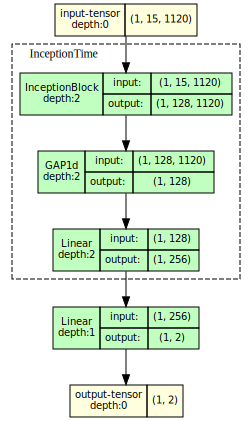

In [15]:
input_channels = 15  # Example input channels
num_classes_lump = 2
model = SingleTaskInceptionTime(input_channels, num_classes_lump)

# Create a dummy input to pass through the model
dummy_input = torch.randn(1, input_channels, 1120)  # Batch size of 1 and sequence length of 1120

# Visualize the model
graph = draw_graph(model, input_size=(1, input_channels, 1120), expand_nested=True, depth=2)
graph.visual_graph

In [16]:
sensor_indices = list(range(15))  # Using all 15 sensors
num_seconds = 7  # Using 7 seconds duration

Using 6 GPUs
Initial Training and Evaluation:


Epoch 1, Training Loss: 0.5761, Validation Loss: 0.5015


Epoch 2, Training Loss: 0.5364, Validation Loss: 0.4243


Epoch 3, Training Loss: 0.5113, Validation Loss: 0.4103


Epoch 4, Training Loss: 0.5038, Validation Loss: 0.4425


Epoch 5, Training Loss: 0.4932, Validation Loss: 0.3959


Epoch 6, Training Loss: 0.4785, Validation Loss: 0.4172


Epoch 7, Training Loss: 0.4689, Validation Loss: 0.4161


Epoch 8, Training Loss: 0.4687, Validation Loss: 0.4293


Epoch 9, Training Loss: 0.4475, Validation Loss: 0.3879


Epoch 10, Training Loss: 0.4427, Validation Loss: 0.4172


Epoch 11, Training Loss: 0.4506, Validation Loss: 0.4238


Epoch 12, Training Loss: 0.4351, Validation Loss: 0.3677


Epoch 13, Training Loss: 0.4238, Validation Loss: 0.3971


Epoch 14, Training Loss: 0.4183, Validation Loss: 0.3677


Epoch 15, Training Loss: 0.4068, Validation Loss: 0.4741


Epoch 16, Training Loss: 0.4136, Validation Loss: 0.3758


Epoch 17, Training Loss: 0.4092, Validation Loss: 0.4300
Early stopping at epoch 17
Training Time: 199.62 seconds


Test Accuracy - Lump: 0.7889

Confusion Matrix - Lump:
[[328  32]
 [120 240]]


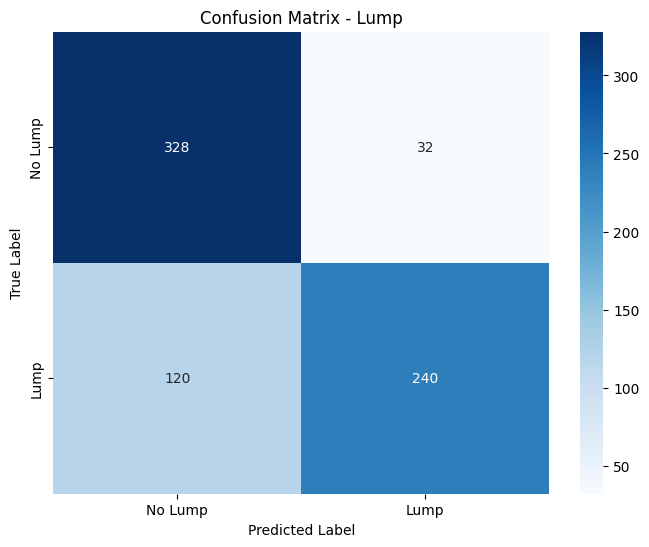


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.73      0.91      0.81       360
        Lump       0.88      0.67      0.76       360

    accuracy                           0.79       720
   macro avg       0.81      0.79      0.79       720
weighted avg       0.81      0.79      0.79       720


Testing on doctors' data without fine-tuning:


Test Accuracy - Lump: 0.5868

Confusion Matrix - Lump:
[[ 25 119]
 [  0 144]]


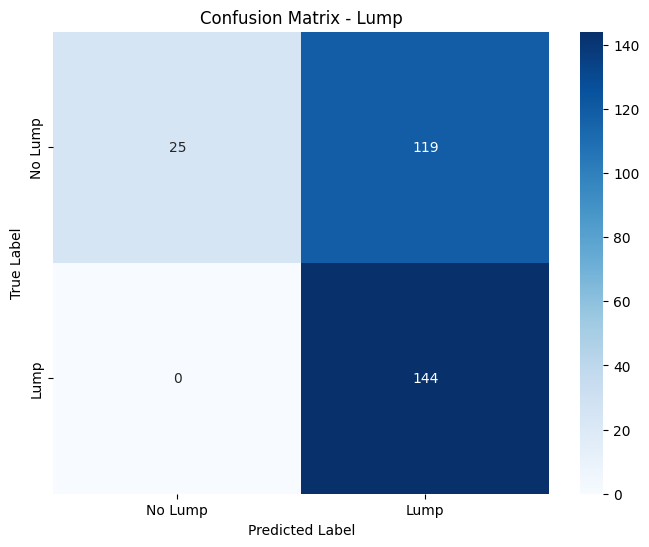


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       1.00      0.17      0.30       144
        Lump       0.55      1.00      0.71       144

    accuracy                           0.59       288
   macro avg       0.77      0.59      0.50       288
weighted avg       0.77      0.59      0.50       288


Fine-tuning with 1 additional trials from new dataset


Epoch 1, Training Loss: 0.4091, Validation Loss: 0.3397


Epoch 2, Training Loss: 0.4070, Validation Loss: 0.3545


Epoch 3, Training Loss: 0.3937, Validation Loss: 0.3423


Epoch 4, Training Loss: 0.3872, Validation Loss: 0.3284


Epoch 5, Training Loss: 0.3760, Validation Loss: 0.4114


Epoch 6, Training Loss: 0.3675, Validation Loss: 0.4198


Epoch 7, Training Loss: 0.3786, Validation Loss: 0.3773


Epoch 8, Training Loss: 0.3799, Validation Loss: 0.3515


Epoch 9, Training Loss: 0.3657, Validation Loss: 0.3273


Epoch 10, Training Loss: 0.3521, Validation Loss: 0.3934


Epoch 11, Training Loss: 0.3679, Validation Loss: 0.3582


Epoch 12, Training Loss: 0.3566, Validation Loss: 0.3098


Epoch 13, Training Loss: 0.3449, Validation Loss: 0.2901


Epoch 14, Training Loss: 0.3455, Validation Loss: 0.3169


Epoch 15, Training Loss: 0.3360, Validation Loss: 0.3463


Epoch 16, Training Loss: 0.3355, Validation Loss: 0.3106


Epoch 17, Training Loss: 0.3223, Validation Loss: 0.3313


Epoch 18, Training Loss: 0.3137, Validation Loss: 0.3010
Early stopping at epoch 18
Training Time: 193.67 seconds


Test Accuracy - Lump: 0.8333

Confusion Matrix - Lump:
[[124  20]
 [ 28 116]]


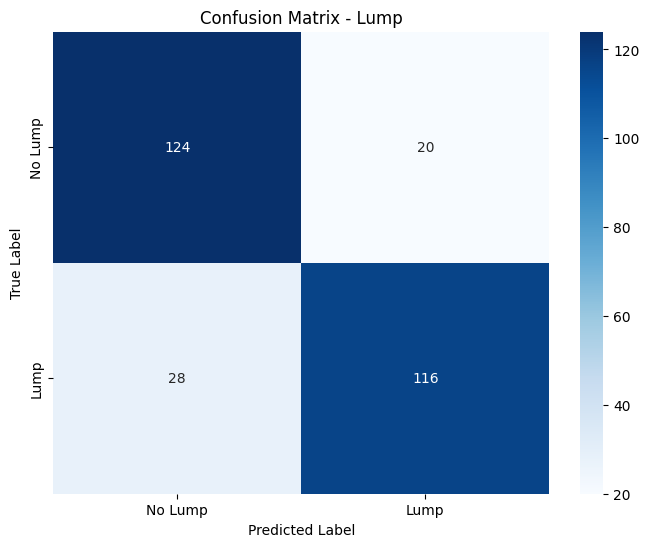


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.82      0.86      0.84       144
        Lump       0.85      0.81      0.83       144

    accuracy                           0.83       288
   macro avg       0.83      0.83      0.83       288
weighted avg       0.83      0.83      0.83       288


Fine-tuning with 2 additional trials from new dataset


Epoch 1, Training Loss: 0.3153, Validation Loss: 0.3140


Epoch 2, Training Loss: 0.3007, Validation Loss: 0.3037


Epoch 3, Training Loss: 0.2971, Validation Loss: 0.3077


Epoch 4, Training Loss: 0.3041, Validation Loss: 0.2967


Epoch 5, Training Loss: 0.2854, Validation Loss: 0.3200
Early stopping at epoch 5
Training Time: 56.71 seconds


Test Accuracy - Lump: 0.6806

Confusion Matrix - Lump:
[[ 58  86]
 [  6 138]]


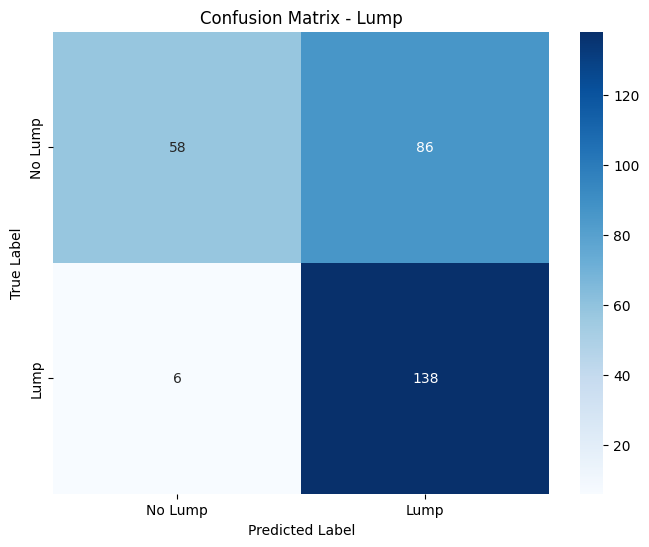


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.91      0.40      0.56       144
        Lump       0.62      0.96      0.75       144

    accuracy                           0.68       288
   macro avg       0.76      0.68      0.65       288
weighted avg       0.76      0.68      0.65       288


Fine-tuning with 3 additional trials from new dataset


Epoch 1, Training Loss: 0.2901, Validation Loss: 0.2688


Epoch 2, Training Loss: 0.2856, Validation Loss: 0.2634


Epoch 3, Training Loss: 0.2885, Validation Loss: 0.2735


Epoch 4, Training Loss: 0.2842, Validation Loss: 0.3068


Epoch 5, Training Loss: 0.2645, Validation Loss: 0.2627


Epoch 6, Training Loss: 0.2656, Validation Loss: 0.3271


Epoch 7, Training Loss: 0.2642, Validation Loss: 0.3155


Epoch 8, Training Loss: 0.2545, Validation Loss: 0.2516


Epoch 9, Training Loss: 0.2492, Validation Loss: 0.2817


Epoch 10, Training Loss: 0.2613, Validation Loss: 0.3161


Epoch 11, Training Loss: 0.2454, Validation Loss: 0.2851


Epoch 12, Training Loss: 0.2484, Validation Loss: 0.2657


Epoch 13, Training Loss: 0.2303, Validation Loss: 0.2964
Early stopping at epoch 13
Training Time: 136.84 seconds


Test Accuracy - Lump: 0.8854

Confusion Matrix - Lump:
[[133  11]
 [ 22 122]]


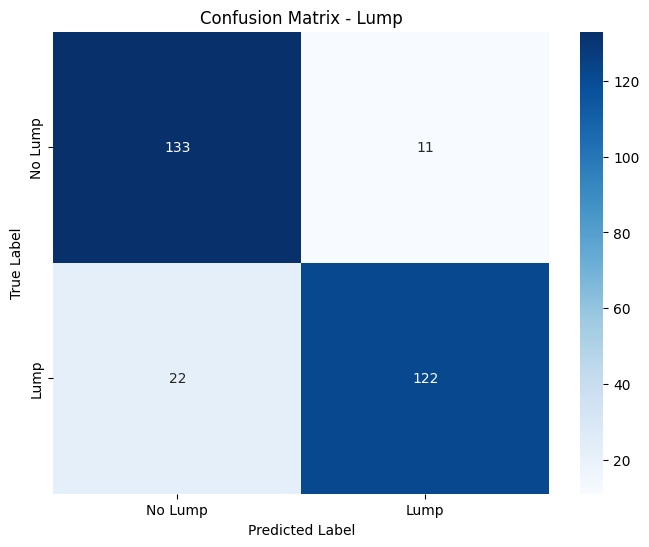


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.86      0.92      0.89       144
        Lump       0.92      0.85      0.88       144

    accuracy                           0.89       288
   macro avg       0.89      0.89      0.89       288
weighted avg       0.89      0.89      0.89       288


Fine-tuning with 4 additional trials from new dataset


Epoch 1, Training Loss: 0.2434, Validation Loss: 0.2850


Epoch 2, Training Loss: 0.2347, Validation Loss: 0.2583


Epoch 3, Training Loss: 0.2278, Validation Loss: 0.2525


Epoch 4, Training Loss: 0.2328, Validation Loss: 0.2562


Epoch 5, Training Loss: 0.2276, Validation Loss: 0.2563
Early stopping at epoch 5
Training Time: 53.07 seconds


Test Accuracy - Lump: 0.8819

Confusion Matrix - Lump:
[[135   9]
 [ 25 119]]


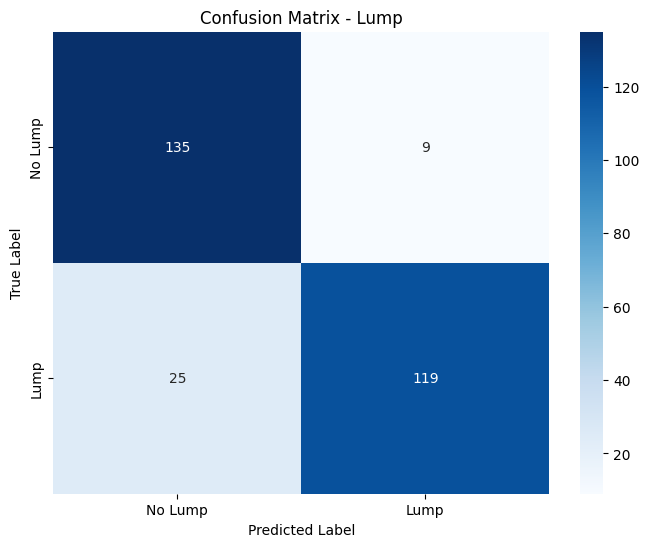


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.84      0.94      0.89       144
        Lump       0.93      0.83      0.88       144

    accuracy                           0.88       288
   macro avg       0.89      0.88      0.88       288
weighted avg       0.89      0.88      0.88       288


Fine-tuning with 5 additional trials from new dataset


Epoch 1, Training Loss: 0.2369, Validation Loss: 0.2316


Epoch 2, Training Loss: 0.2091, Validation Loss: 0.2426


Epoch 3, Training Loss: 0.2358, Validation Loss: 0.2607


Epoch 4, Training Loss: 0.2285, Validation Loss: 0.2576


Epoch 5, Training Loss: 0.2171, Validation Loss: 0.2649


Epoch 6, Training Loss: 0.2124, Validation Loss: 0.2526
Early stopping at epoch 6
Training Time: 61.62 seconds


Test Accuracy - Lump: 0.9028

Confusion Matrix - Lump:
[[124  20]
 [  8 136]]


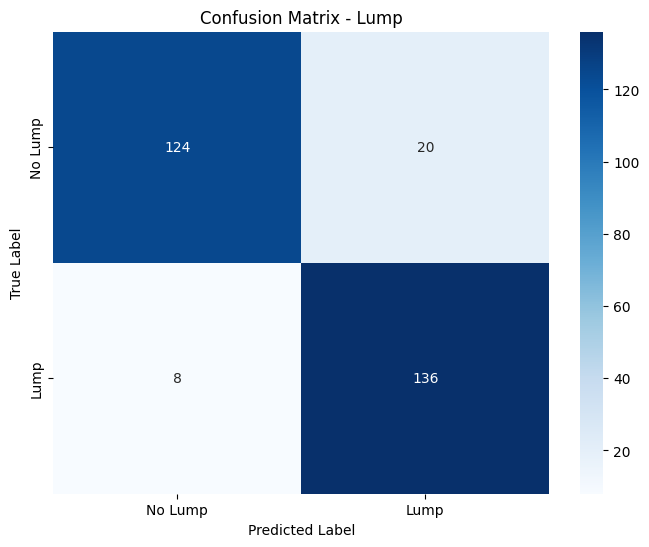


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.94      0.86      0.90       144
        Lump       0.87      0.94      0.91       144

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288


Fine-tuning with 6 additional trials from new dataset


Epoch 1, Training Loss: 0.2093, Validation Loss: 0.2205


Epoch 2, Training Loss: 0.2046, Validation Loss: 0.2611


Epoch 3, Training Loss: 0.1984, Validation Loss: 0.2911


Epoch 4, Training Loss: 0.2018, Validation Loss: 0.2253


Epoch 5, Training Loss: 0.1954, Validation Loss: 0.3086


Epoch 6, Training Loss: 0.1828, Validation Loss: 0.2393
Early stopping at epoch 6
Training Time: 60.83 seconds


Test Accuracy - Lump: 0.8576

Confusion Matrix - Lump:
[[138   6]
 [ 35 109]]


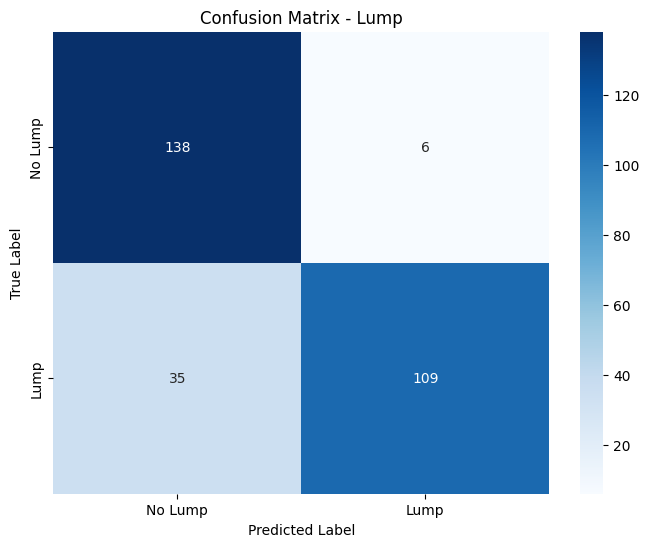


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.80      0.96      0.87       144
        Lump       0.95      0.76      0.84       144

    accuracy                           0.86       288
   macro avg       0.87      0.86      0.86       288
weighted avg       0.87      0.86      0.86       288


Fine-tuning with 7 additional trials from new dataset


Epoch 1, Training Loss: 0.1939, Validation Loss: 0.2431


Epoch 2, Training Loss: 0.1817, Validation Loss: 0.2844


Epoch 3, Training Loss: 0.1971, Validation Loss: 0.2754


Epoch 4, Training Loss: 0.1790, Validation Loss: 0.2310


Epoch 5, Training Loss: 0.1742, Validation Loss: 0.2226
Early stopping at epoch 5
Training Time: 51.37 seconds


Test Accuracy - Lump: 0.9167

Confusion Matrix - Lump:
[[141   3]
 [ 21 123]]


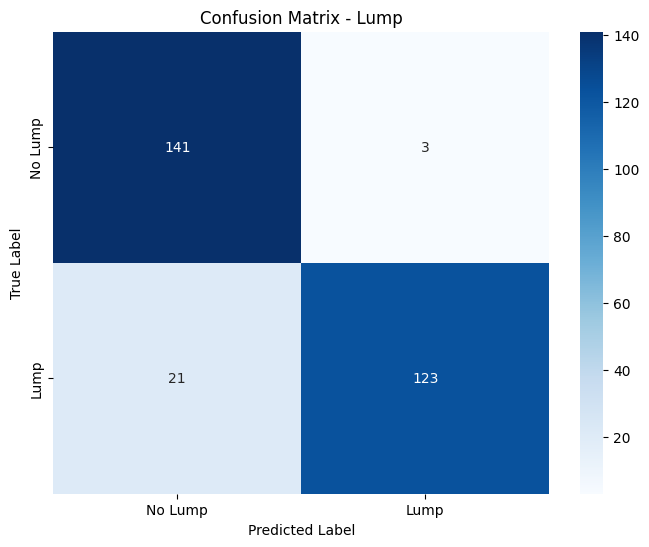


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.87      0.98      0.92       144
        Lump       0.98      0.85      0.91       144

    accuracy                           0.92       288
   macro avg       0.92      0.92      0.92       288
weighted avg       0.92      0.92      0.92       288


Fine-tuning with 8 additional trials from new dataset


Epoch 1, Training Loss: 0.1737, Validation Loss: 0.2715


Epoch 2, Training Loss: 0.1791, Validation Loss: 0.2577


Epoch 3, Training Loss: 0.1666, Validation Loss: 0.2216


Epoch 4, Training Loss: 0.1659, Validation Loss: 0.2823


Epoch 5, Training Loss: 0.1721, Validation Loss: 0.2344
Early stopping at epoch 5
Training Time: 51.15 seconds


Test Accuracy - Lump: 0.8715

Confusion Matrix - Lump:
[[142   2]
 [ 35 109]]


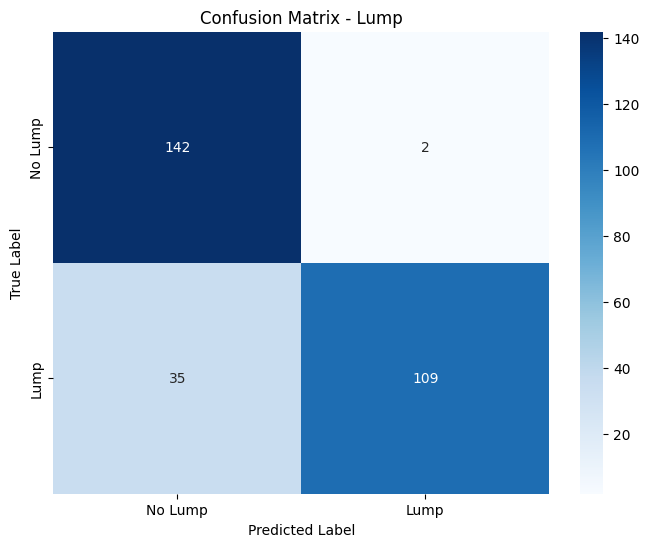


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.80      0.99      0.88       144
        Lump       0.98      0.76      0.85       144

    accuracy                           0.87       288
   macro avg       0.89      0.87      0.87       288
weighted avg       0.89      0.87      0.87       288


Fine-tuning with 9 additional trials from new dataset


Epoch 1, Training Loss: 0.1754, Validation Loss: 0.2618


Epoch 2, Training Loss: 0.1747, Validation Loss: 0.2626


Epoch 3, Training Loss: 0.1613, Validation Loss: 0.2615


Epoch 4, Training Loss: 0.1580, Validation Loss: 0.2402


Epoch 5, Training Loss: 0.1644, Validation Loss: 0.2416
Early stopping at epoch 5
Training Time: 52.51 seconds


Test Accuracy - Lump: 0.9271

Confusion Matrix - Lump:
[[137   7]
 [ 14 130]]


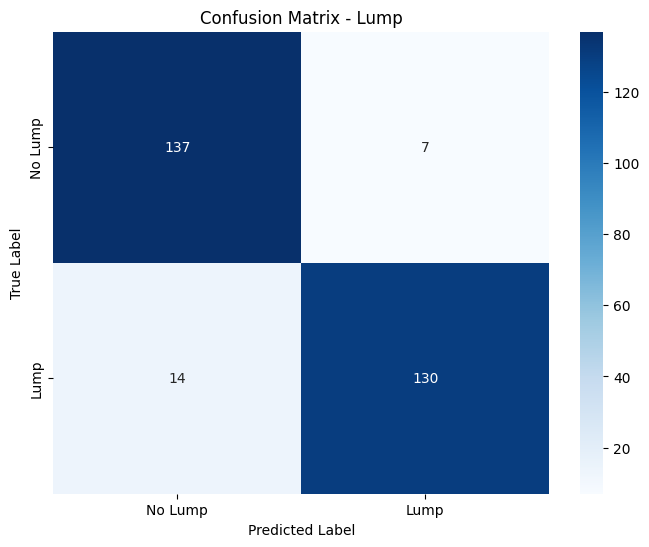


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.91      0.95      0.93       144
        Lump       0.95      0.90      0.93       144

    accuracy                           0.93       288
   macro avg       0.93      0.93      0.93       288
weighted avg       0.93      0.93      0.93       288


Fine-tuning with 10 additional trials from new dataset


Epoch 1, Training Loss: 0.1544, Validation Loss: 0.2520


Epoch 2, Training Loss: 0.1565, Validation Loss: 0.2565


Epoch 3, Training Loss: 0.1640, Validation Loss: 0.2689


Epoch 4, Training Loss: 0.1467, Validation Loss: 0.2944


Epoch 5, Training Loss: 0.1642, Validation Loss: 0.2680
Early stopping at epoch 5
Training Time: 54.93 seconds


Test Accuracy - Lump: 0.9236

Confusion Matrix - Lump:
[[138   6]
 [ 16 128]]


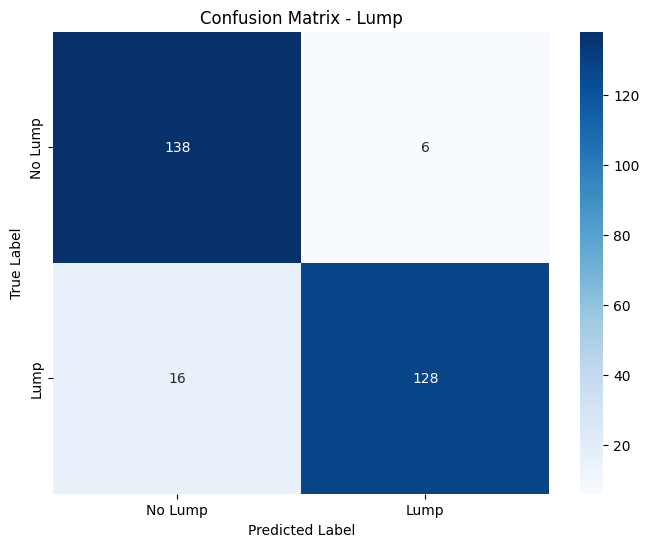


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.90      0.96      0.93       144
        Lump       0.96      0.89      0.92       144

    accuracy                           0.92       288
   macro avg       0.93      0.92      0.92       288
weighted avg       0.93      0.92      0.92       288


Fine-tuning with 11 additional trials from new dataset


Epoch 1, Training Loss: 0.1632, Validation Loss: 0.2353


Epoch 2, Training Loss: 0.1377, Validation Loss: 0.2582


Epoch 3, Training Loss: 0.1525, Validation Loss: 0.2576


Epoch 4, Training Loss: 0.1514, Validation Loss: 0.2732


Epoch 5, Training Loss: 0.1358, Validation Loss: 0.2175


Epoch 6, Training Loss: 0.1346, Validation Loss: 0.3115


Epoch 7, Training Loss: 0.1587, Validation Loss: 0.2989


Epoch 8, Training Loss: 0.1365, Validation Loss: 0.2154


Epoch 9, Training Loss: 0.1349, Validation Loss: 0.2684


Epoch 10, Training Loss: 0.1253, Validation Loss: 0.2365


Epoch 11, Training Loss: 0.1493, Validation Loss: 0.2758


Epoch 12, Training Loss: 0.1304, Validation Loss: 0.3863


Epoch 13, Training Loss: 0.1271, Validation Loss: 0.2659
Early stopping at epoch 13
Training Time: 138.32 seconds


Test Accuracy - Lump: 0.9444

Confusion Matrix - Lump:
[[134  10]
 [  6 138]]


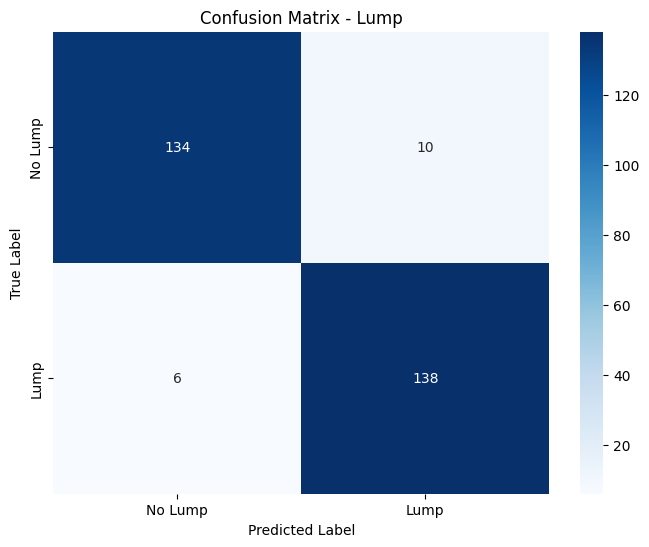


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.96      0.93      0.94       144
        Lump       0.93      0.96      0.95       144

    accuracy                           0.94       288
   macro avg       0.94      0.94      0.94       288
weighted avg       0.94      0.94      0.94       288


Fine-tuning with 12 additional trials from new dataset


Epoch 1, Training Loss: 0.1356, Validation Loss: 0.2317


Epoch 2, Training Loss: 0.1203, Validation Loss: 0.2447


Epoch 3, Training Loss: 0.1287, Validation Loss: 0.2384


Epoch 4, Training Loss: 0.1171, Validation Loss: 0.2502


Epoch 5, Training Loss: 0.1289, Validation Loss: 0.1998


Epoch 6, Training Loss: 0.1202, Validation Loss: 0.2757


Epoch 7, Training Loss: 0.1111, Validation Loss: 0.2424


Epoch 8, Training Loss: 0.1160, Validation Loss: 0.2537


Epoch 9, Training Loss: 0.1111, Validation Loss: 0.2837


Epoch 10, Training Loss: 0.1195, Validation Loss: 0.2386
Early stopping at epoch 10
Training Time: 106.91 seconds


Test Accuracy - Lump: 0.9549

Confusion Matrix - Lump:
[[138   6]
 [  7 137]]


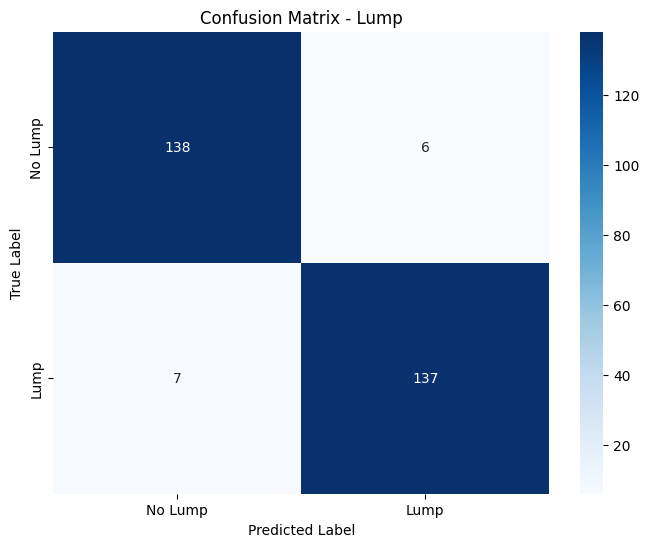


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.95      0.96      0.96       144
        Lump       0.96      0.95      0.95       144

    accuracy                           0.95       288
   macro avg       0.95      0.95      0.95       288
weighted avg       0.95      0.95      0.95       288

Few-shot early stopping at step 12


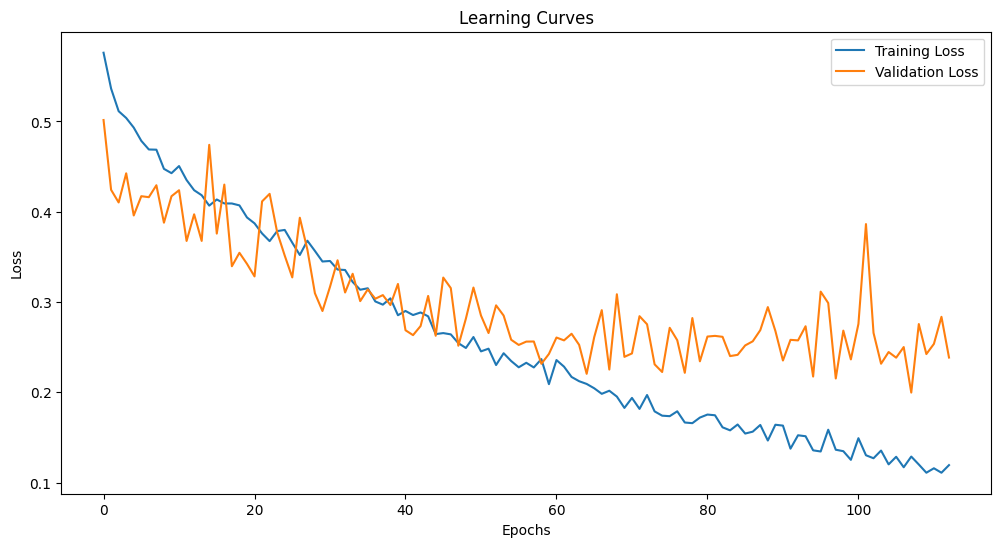

| Training Phase                         |   Lump Accuracy |   Training Time |
|:---------------------------------------|----------------:|----------------:|
| Initial Training                       |        0.788889 |        199.617  |
| Testing on doctors without fine-tuning |        0.586806 |          0      |
| Fine-tuning with 1 trials              |        0.833333 |        193.672  |
| Fine-tuning with 2 trials              |        0.680556 |         56.7131 |
| Fine-tuning with 3 trials              |        0.885417 |        136.841  |
| Fine-tuning with 4 trials              |        0.881944 |         53.0694 |
| Fine-tuning with 5 trials              |        0.902778 |         61.6205 |
| Fine-tuning with 6 trials              |        0.857639 |         60.8271 |
| Fine-tuning with 7 trials              |        0.916667 |         51.3688 |
| Fine-tuning with 8 trials              |        0.871528 |         51.149  |
| Fine-tuning with 9 trials              |        0.

In [17]:
initial_accuracies, fine_tune_accuracies = train_single_task_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=doctors_df, few_shot_steps=50)

Using 6 GPUs
Initial Training and Evaluation:


Epoch 1, Training Loss: 0.5913, Validation Loss: 0.5070


Epoch 2, Training Loss: 0.5351, Validation Loss: 0.4645


Epoch 3, Training Loss: 0.5029, Validation Loss: 0.5028


Epoch 4, Training Loss: 0.5028, Validation Loss: 0.4515


Epoch 5, Training Loss: 0.4776, Validation Loss: 0.4272


Epoch 6, Training Loss: 0.4859, Validation Loss: 0.4551


Epoch 7, Training Loss: 0.4581, Validation Loss: 0.4042


Epoch 8, Training Loss: 0.4558, Validation Loss: 0.4117


Epoch 9, Training Loss: 0.4436, Validation Loss: 0.3564


Epoch 10, Training Loss: 0.4369, Validation Loss: 0.3985


Epoch 11, Training Loss: 0.4399, Validation Loss: 0.3674


Epoch 12, Training Loss: 0.4311, Validation Loss: 0.3950


Epoch 13, Training Loss: 0.4104, Validation Loss: 0.3418


Epoch 14, Training Loss: 0.3985, Validation Loss: 0.3754


Epoch 15, Training Loss: 0.4046, Validation Loss: 0.3540


Epoch 16, Training Loss: 0.3964, Validation Loss: 0.3747


Epoch 17, Training Loss: 0.3776, Validation Loss: 0.3899


Epoch 18, Training Loss: 0.3928, Validation Loss: 0.4061
Early stopping at epoch 18
Training Time: 192.56 seconds


Test Accuracy - Lump: 0.7778

Confusion Matrix - Lump:
[[342  18]
 [142 218]]


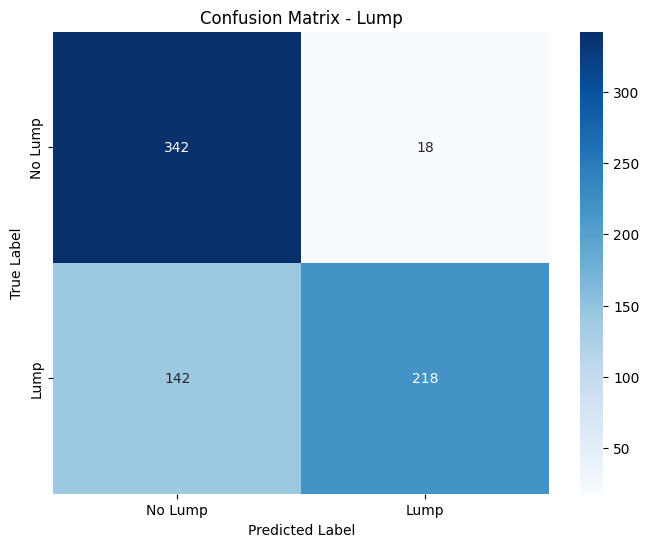


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.71      0.95      0.81       360
        Lump       0.92      0.61      0.73       360

    accuracy                           0.78       720
   macro avg       0.82      0.78      0.77       720
weighted avg       0.82      0.78      0.77       720


Testing on doctors' data without fine-tuning:


Test Accuracy - Lump: 0.3194

Confusion Matrix - Lump:
[[ 27 117]
 [ 79  65]]


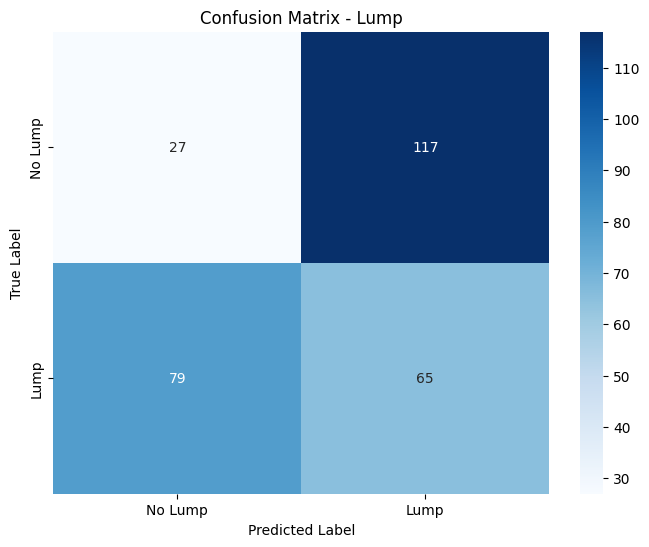


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.25      0.19      0.22       144
        Lump       0.36      0.45      0.40       144

    accuracy                           0.32       288
   macro avg       0.31      0.32      0.31       288
weighted avg       0.31      0.32      0.31       288


Fine-tuning with 1 additional trials from new dataset


Epoch 1, Training Loss: 0.3790, Validation Loss: 0.3368


Epoch 2, Training Loss: 0.3618, Validation Loss: 0.3537


Epoch 3, Training Loss: 0.3469, Validation Loss: 0.4315


Epoch 4, Training Loss: 0.3473, Validation Loss: 0.3264


Epoch 5, Training Loss: 0.3449, Validation Loss: 0.3038


Epoch 6, Training Loss: 0.3473, Validation Loss: 0.3316


Epoch 7, Training Loss: 0.3398, Validation Loss: 0.3269


Epoch 8, Training Loss: 0.3130, Validation Loss: 0.3566


Epoch 9, Training Loss: 0.3173, Validation Loss: 0.3423


Epoch 10, Training Loss: 0.3068, Validation Loss: 0.3618
Early stopping at epoch 10
Training Time: 104.99 seconds


Test Accuracy - Lump: 0.5104

Confusion Matrix - Lump:
[[144   0]
 [141   3]]


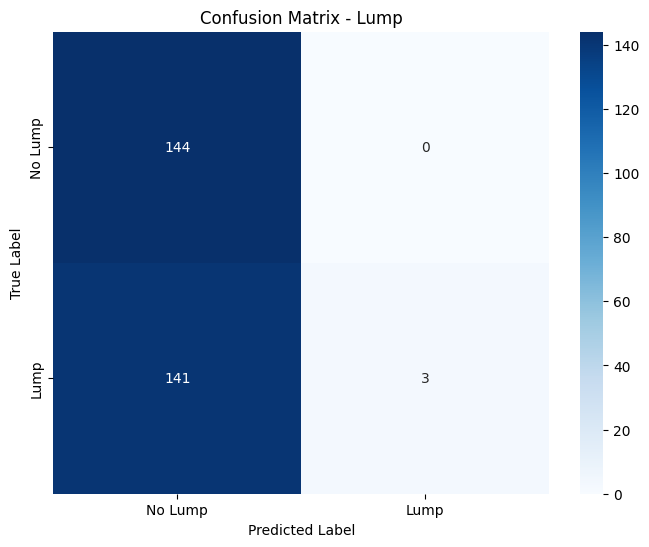


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.51      1.00      0.67       144
        Lump       1.00      0.02      0.04       144

    accuracy                           0.51       288
   macro avg       0.75      0.51      0.36       288
weighted avg       0.75      0.51      0.36       288


Fine-tuning with 2 additional trials from new dataset


Epoch 1, Training Loss: 0.3193, Validation Loss: 0.3013


Epoch 2, Training Loss: 0.2937, Validation Loss: 0.3839


Epoch 3, Training Loss: 0.2883, Validation Loss: 0.3196


Epoch 4, Training Loss: 0.2991, Validation Loss: 0.2832


Epoch 5, Training Loss: 0.2889, Validation Loss: 0.3349


Epoch 6, Training Loss: 0.2795, Validation Loss: 0.3223


Epoch 7, Training Loss: 0.2808, Validation Loss: 0.2761


Epoch 8, Training Loss: 0.2728, Validation Loss: 0.3340


Epoch 9, Training Loss: 0.2785, Validation Loss: 0.2740


Epoch 10, Training Loss: 0.2717, Validation Loss: 0.2605


Epoch 11, Training Loss: 0.2561, Validation Loss: 0.2890


Epoch 12, Training Loss: 0.2619, Validation Loss: 0.3223


Epoch 13, Training Loss: 0.2544, Validation Loss: 0.3006


Epoch 14, Training Loss: 0.2605, Validation Loss: 0.3003


Epoch 15, Training Loss: 0.2503, Validation Loss: 0.2524


Epoch 16, Training Loss: 0.2398, Validation Loss: 0.2792


Epoch 17, Training Loss: 0.2387, Validation Loss: 0.2764


Epoch 18, Training Loss: 0.2368, Validation Loss: 0.2878


Epoch 19, Training Loss: 0.2253, Validation Loss: 0.3015


Epoch 20, Training Loss: 0.2293, Validation Loss: 0.2674
Early stopping at epoch 20
Training Time: 208.98 seconds


Test Accuracy - Lump: 0.7639

Confusion Matrix - Lump:
[[ 83  61]
 [  7 137]]


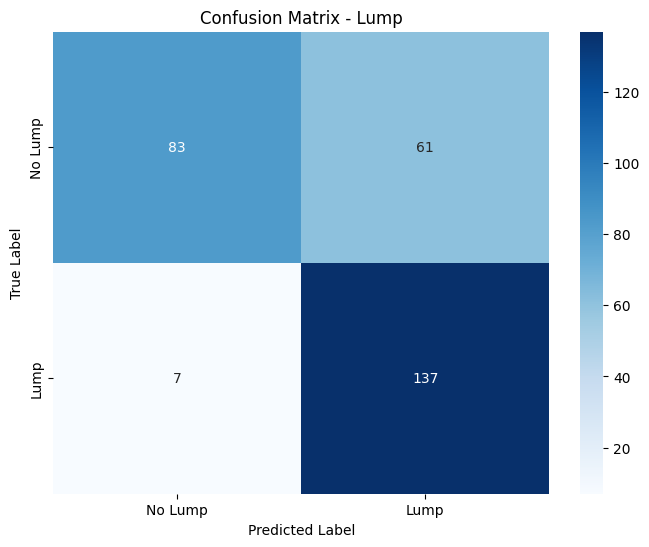


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.92      0.58      0.71       144
        Lump       0.69      0.95      0.80       144

    accuracy                           0.76       288
   macro avg       0.81      0.76      0.76       288
weighted avg       0.81      0.76      0.76       288


Fine-tuning with 3 additional trials from new dataset


Epoch 1, Training Loss: 0.2425, Validation Loss: 0.3570


Epoch 2, Training Loss: 0.2377, Validation Loss: 0.2816


Epoch 3, Training Loss: 0.2285, Validation Loss: 0.3480


Epoch 4, Training Loss: 0.2232, Validation Loss: 0.3369


Epoch 5, Training Loss: 0.2237, Validation Loss: 0.2759
Early stopping at epoch 5
Training Time: 52.73 seconds


Test Accuracy - Lump: 0.8368

Confusion Matrix - Lump:
[[124  20]
 [ 27 117]]


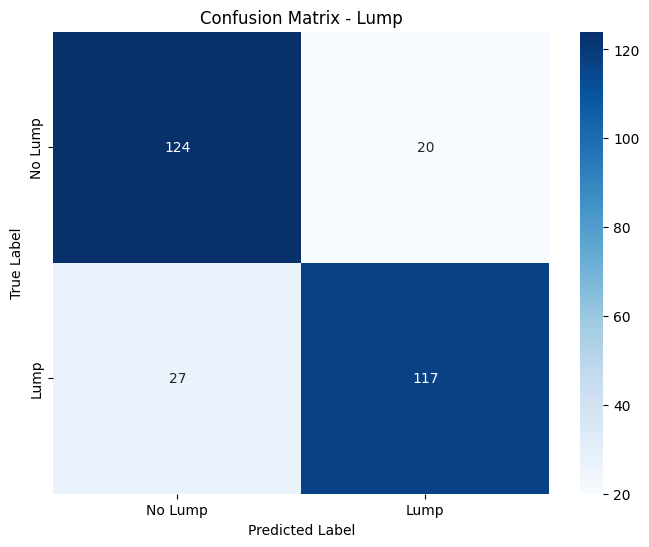


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.82      0.86      0.84       144
        Lump       0.85      0.81      0.83       144

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288


Fine-tuning with 4 additional trials from new dataset


Epoch 1, Training Loss: 0.2242, Validation Loss: 0.2789


Epoch 2, Training Loss: 0.2268, Validation Loss: 0.3091


Epoch 3, Training Loss: 0.2062, Validation Loss: 0.3389


Epoch 4, Training Loss: 0.2016, Validation Loss: 0.3067


Epoch 5, Training Loss: 0.2110, Validation Loss: 0.2979
Early stopping at epoch 5
Training Time: 51.34 seconds


Test Accuracy - Lump: 0.7743

Confusion Matrix - Lump:
[[140   4]
 [ 61  83]]


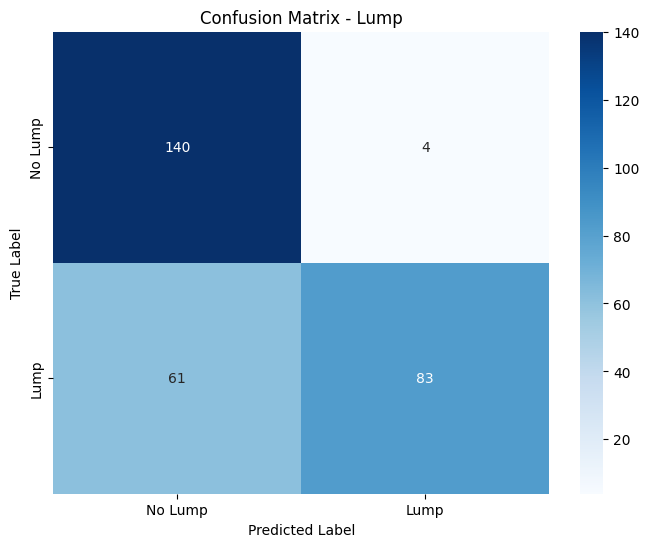


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.70      0.97      0.81       144
        Lump       0.95      0.58      0.72       144

    accuracy                           0.77       288
   macro avg       0.83      0.77      0.77       288
weighted avg       0.83      0.77      0.77       288


Fine-tuning with 5 additional trials from new dataset


Epoch 1, Training Loss: 0.1987, Validation Loss: 0.3321


Epoch 2, Training Loss: 0.1936, Validation Loss: 0.2458


Epoch 3, Training Loss: 0.1955, Validation Loss: 0.2866


Epoch 4, Training Loss: 0.2090, Validation Loss: 0.2540


Epoch 5, Training Loss: 0.1988, Validation Loss: 0.2786


Epoch 6, Training Loss: 0.1895, Validation Loss: 0.3225


Epoch 7, Training Loss: 0.2036, Validation Loss: 0.2824
Early stopping at epoch 7
Training Time: 69.61 seconds


Test Accuracy - Lump: 0.9028

Confusion Matrix - Lump:
[[127  17]
 [ 11 133]]


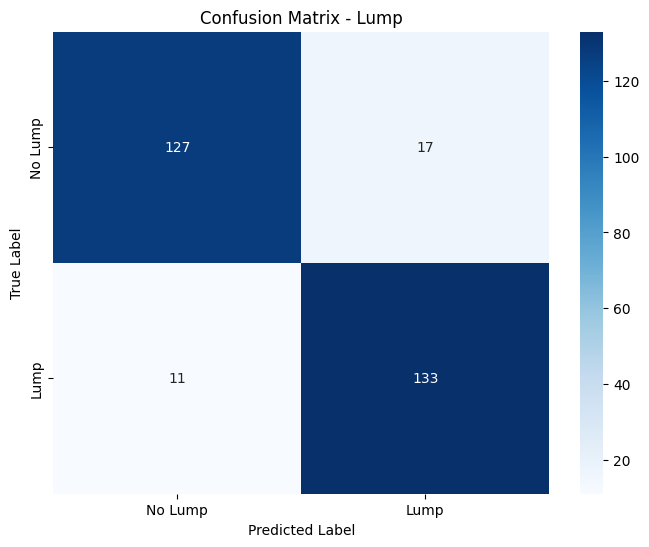


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.92      0.88      0.90       144
        Lump       0.89      0.92      0.90       144

    accuracy                           0.90       288
   macro avg       0.90      0.90      0.90       288
weighted avg       0.90      0.90      0.90       288


Fine-tuning with 6 additional trials from new dataset


Epoch 1, Training Loss: 0.1783, Validation Loss: 0.3654


Epoch 2, Training Loss: 0.1878, Validation Loss: 0.2780


Epoch 3, Training Loss: 0.1690, Validation Loss: 0.3256


Epoch 4, Training Loss: 0.1888, Validation Loss: 0.2514


Epoch 5, Training Loss: 0.1834, Validation Loss: 0.2688
Early stopping at epoch 5
Training Time: 52.17 seconds


Test Accuracy - Lump: 0.7743

Confusion Matrix - Lump:
[[142   2]
 [ 63  81]]


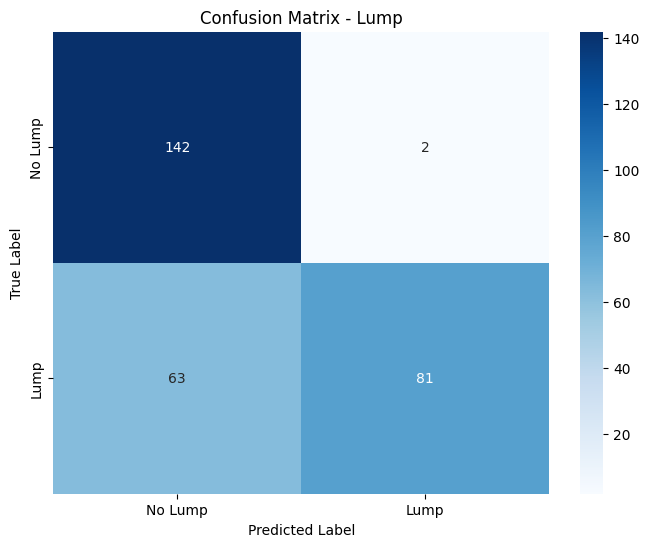


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.69      0.99      0.81       144
        Lump       0.98      0.56      0.71       144

    accuracy                           0.77       288
   macro avg       0.83      0.77      0.76       288
weighted avg       0.83      0.77      0.76       288


Fine-tuning with 7 additional trials from new dataset


Epoch 1, Training Loss: 0.1874, Validation Loss: 0.2742


Epoch 2, Training Loss: 0.1761, Validation Loss: 0.2800


Epoch 3, Training Loss: 0.1965, Validation Loss: 0.2714


Epoch 4, Training Loss: 0.1700, Validation Loss: 0.2725


Epoch 5, Training Loss: 0.1787, Validation Loss: 0.2697
Early stopping at epoch 5
Training Time: 53.90 seconds


Test Accuracy - Lump: 0.8924

Confusion Matrix - Lump:
[[128  16]
 [ 15 129]]


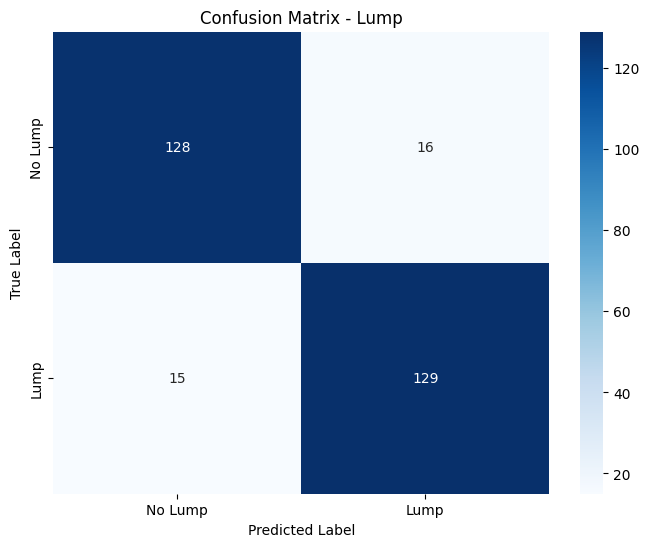


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.90      0.89      0.89       144
        Lump       0.89      0.90      0.89       144

    accuracy                           0.89       288
   macro avg       0.89      0.89      0.89       288
weighted avg       0.89      0.89      0.89       288

Few-shot early stopping at step 7


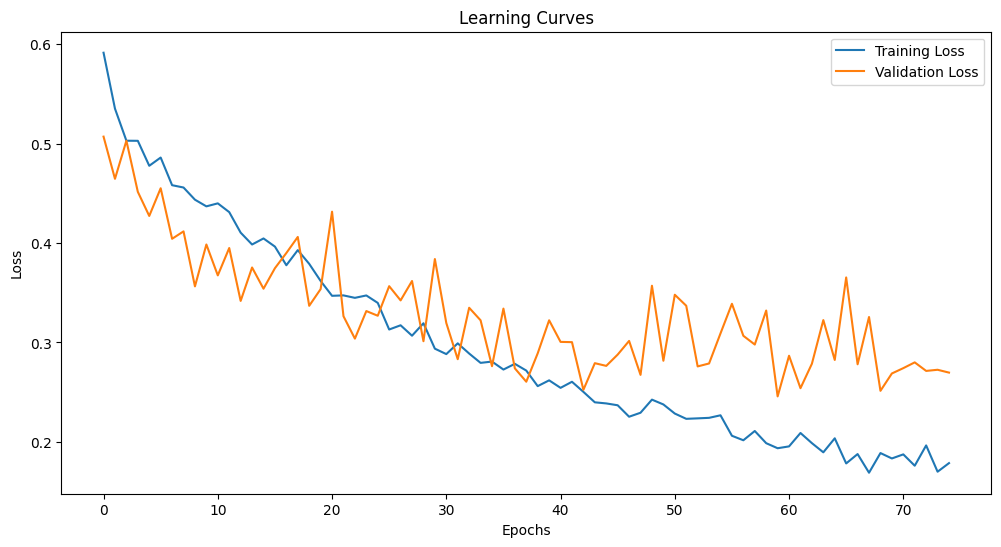

| Training Phase                         |   Lump Accuracy |   Training Time |
|:---------------------------------------|----------------:|----------------:|
| Initial Training                       |        0.777778 |        192.556  |
| Testing on doctors without fine-tuning |        0.319444 |          0      |
| Fine-tuning with 1 trials              |        0.510417 |        104.987  |
| Fine-tuning with 2 trials              |        0.763889 |        208.984  |
| Fine-tuning with 3 trials              |        0.836806 |         52.7276 |
| Fine-tuning with 4 trials              |        0.774306 |         51.3447 |
| Fine-tuning with 5 trials              |        0.902778 |         69.6137 |
| Fine-tuning with 6 trials              |        0.774306 |         52.1701 |
| Fine-tuning with 7 trials              |        0.892361 |         53.9022 |


In [18]:
initial_accuracies, fine_tune_accuracies = train_single_task_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=doctors_df, few_shot_steps=50)